In [72]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sklearn.set_config(display=”diagram”)

<font size=6>
    Sberbank Russian Housing Market
</font>

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>
<font color='red' size=5>
    The show so far ... 
</font>


**Summary**

1. Load data
2. Remove features
    * features missing more than 10%
    * features with high correlations to the other features
        * used hierarchical correlation dropper
3. Stage 1 transformations:
    * Ignored features: 
        * e.g. 'id' and 'datetime' columns
    * Scale num. features
        * perhaps better to wait until after 
            1. cat. encoding is done with ordinals
            2. imputation for (all) features
    * Cat. features
        * used Ordinal and OneHot-encoders
        * used custom encoder to include NANs
    * Retrieve column names        
    * Recast all features as needed
4. Stage 2 transformations:
    * Ignored features: 
        * e.g. 'id' and 'datetime' columns
    * Impute remaining features
        * Used `SimpleImputer`
        * `KNNImputer` failed
    * Retrieve column names
    * Recast all features as needed

5. Modeling

6. Evaluate errors

7. Feature importance

**TODOs**

0. Priorities
   1. Remove the target feature for the pipeline?
        * if the pipeline is fit for the independent features, then it should work with them alone;
        * whatever preprocessing is needed for the target feature can be done independently, outside of the pipeline 
   
1. $\checkmark$ ~~Get the columns names of the transformed data after the `Pipeline` / `ColumnTransformer` steps~~
    * _Needed for checking, further exploration, and featuring engineering_
2. Check on the appropriate strategies
    * $\checkmark$ ~~first do cat. encoding with `ColumnTransformer`, then do scaling on numericals in another `Pipeline`~~
    * ~~do everything in a single `Pipeline` taking care of the steps~~ $\to$ everything done with `ColumnTransformer` instead
        * allows individual selection of features for transformations
    * ~~Drop features with many unfilled values (can't do _after_ imputing) or just impute?, then pipeline~~ 
        * $\checkmark$ ~~Drop features with many unfilled values before/after preprocessing?~~
        * $\checkmark$ ~~impute afterwards~~
3. $\checkmark$ ~~Drop features which are mutually correlated; keep only the most relevant ones~~
    * **!!!** do this before first preprocessing stage?
4. More EDA
    * Identify quantities to be removed:
        * IDs which contribute to the spikes in the neg. tail of the 'price_doc' distribution
            * or see if they're correlated with another feature, like 'sub_area'
            * **UNFINISHED** 
                * wasn't an early sign that this was the case
                * is it possible to automatically detect narrow-bin spikes in a distribution? and eleminate the rows which contribute to them?
        * $\checkmark$ ~~check the distribution of the 'sub_area' feature~~
            * ~~are there enough samples for each category?~~ 
5. More feature engineering
    * There are a few more things which can be done to see if there's an improvement:
        * removing some IDs (rows) which have some outlier behavior (clearly defined spikes in distributions)
        * aggregating some features together (e.g. combining nearby 'sub_areas') $\to$ needs some ad hoc investigations
        * $\checkmark$ Using the classifiers to identify and reduce the number of features to only the important ones. $\to$ **TODO** need to save the results       
6. Try to package up the routine into a single stage with a multistep pipeline
    * The issue is keeping track of the columns since the stages work on different subsets;
    * An idea would be to
        1. Order the columns first by datatype
        2. Then do the structure-preserving transformations (transformations which preserve the number of columns) like scaling, ordinal encoding, imputing(?))
        3. Then do the transformations like OneHotEnc 

            
**Notes**
* All transforms were included with `ColumnTransformer`
    * selects cols individually
    * can act as a pipeline
    * retrieve the columns names and ordering
        * _this is important to do the next steps of processing_

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 2.0px;"/>

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
import os

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 20)]
random.shuffle(colors)

In [6]:
#import importlib
import sys
sys.path.append('./helpers/')

## Load the data

In [86]:
df = pd.read_csv('../../datasets/sberbank-russian-housing-market/train.csv', \
                 infer_datetime_format=True, parse_dates=['timestamp'])

In [87]:
df.shape

(30471, 292)

Get the dtypes of the DF; save to a dict for later use

In [88]:
df_dtypes = df.dtypes.reset_index().rename(columns={'index':'column', 0:'datatype'})
df_dtype_dict = dict(zip(df_dtypes.column, df_dtypes.datatype.astype(str)))

### Feature work

#### Separate the target feature

**Note** the target feature may also need to be transformed, _e.g._ rescaled

In [89]:
target_feature = 'price_doc'
target_col = [target_feature]

In [92]:
df[target_col].head()

,price_doc
0,5850000
1,6000000
2,5700000
3,13100000
4,16331452


In [93]:
df_targ = df[target_col].copy()

In [97]:
df = df.drop(columns=target_feature)

#### Separate some features based on type and/or use

##### Identify the numerical features

In [21]:
ignore_cols = ['id','timestamp']

In [22]:
float_cols = df.drop(columns=ignore_cols+target_col).select_dtypes('float').columns.tolist()

int_cols = df.drop(columns=ignore_cols+target_col).select_dtypes('int').columns.tolist()

num_cols = df.drop(columns=ignore_cols+target_col).select_dtypes(['int', 'float']).columns.tolist()

Select the categorical features

In [23]:
string_cols = df.drop(columns=ignore_cols+target_col).select_dtypes('object').columns.tolist()

## Preprocess the data

### Drop features

#### Characterize the missing values

In [10]:
from helpers.fill_rates import get_column_fill_rates, get_row_fill_rates

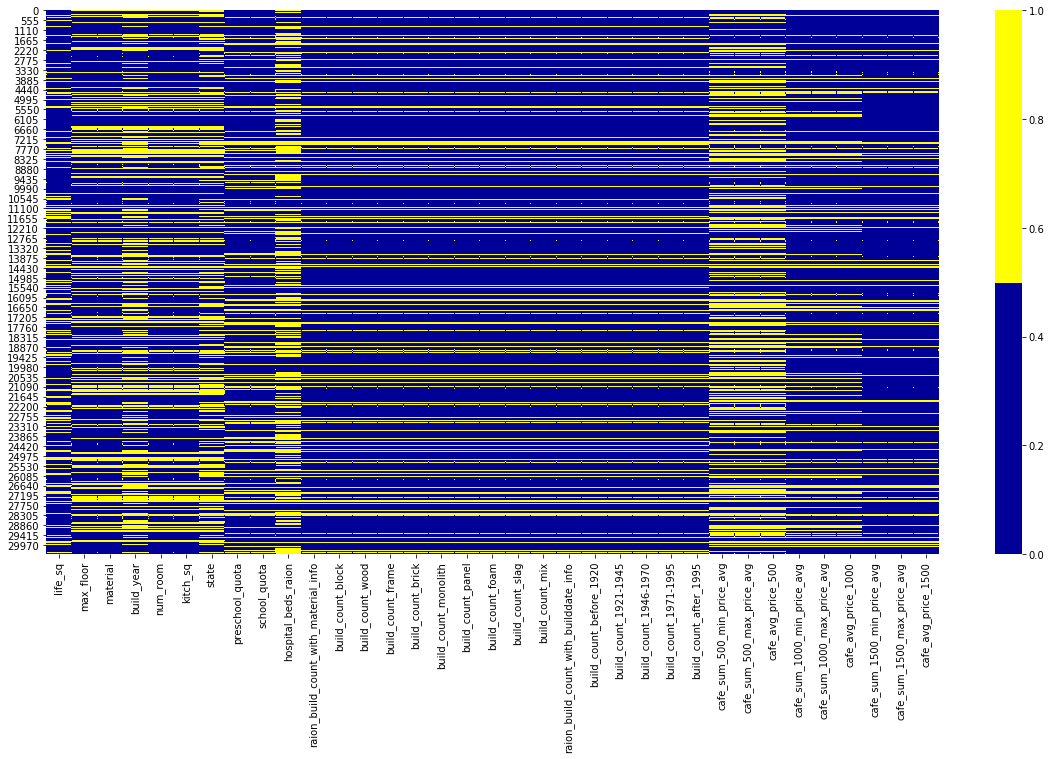

In [11]:
df_fillrates = get_column_fill_rates(df,0.0)
unfilled_cols = df_fillrates[df_fillrates['frac_full']<=0.90]['column_name'].tolist()

plt.figure(figsize=[20,10])
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[unfilled_cols].isnull().sample(frac=1).reset_index(drop=True), cmap=sns.color_palette(colours))

##### Check the fill rate of the features

Keep all features having more than 90% (arbitrary) of their values

In [12]:
threshold = 0.90
df_fillrates = get_column_fill_rates(df,threshold)
display(df_fillrates.sort_values("frac_full", ascending=True)[:10])

,column_name,frac_full
229,cafe_sum_2000_min_price_avg,0.943389
230,cafe_sum_2000_max_price_avg,0.943389
231,cafe_avg_price_2000,0.943389
252,cafe_sum_3000_min_price_avg,0.967477
254,cafe_avg_price_3000,0.967477
253,cafe_sum_3000_max_price_avg,0.967477
275,cafe_sum_5000_min_price_avg,0.990253
276,cafe_sum_5000_max_price_avg,0.990253
277,cafe_avg_price_5000,0.990253
269,prom_part_5000,0.994158


In [13]:
filled_cols = df_fillrates.column_name.tolist()
print(f'Number of features more than {round(100*threshold)}% filled: { len(filled_cols)}')

Number of features more than 90% filled: 257


##### Check the fill rate of the rows

**Note** this is passive; nothing is done with this info; it will also change when the unfilled features are removed

In [14]:
threshold = 0.85
df_fillrates = get_row_fill_rates(df,threshold)
display(df_fillrates.sort_values("frac_full", ascending=True)[:10])

,id,row_counts,frac_full
3589,3589,249,0.852740
20231,20231,251,0.859589
5094,5094,251,0.859589
8474,8474,251,0.859589
7972,7972,251,0.859589
7172,7172,251,0.859589
7902,7902,251,0.859589
22097,22097,251,0.859589
5105,5105,251,0.859589
5277,5277,251,0.859589


In [15]:
print(f'Number of features more than {round(100*threshold)}% filled: { df_fillrates.shape[0]}')

Number of features more than 85% filled: 30470


##### Check the information content of the features

If the features contain little useful information (_ie_ they have low variance), they might not contribute much to the model. 
<br/>
For efficiecy reasons, it might be best to drop these, though the resulting model will likely be unchanged.

In [16]:
num_rows = len(df.index)
low_information_cols = [] #

for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

oil_chemistry_raion: 99.02858%
no     30175
yes      296
Name: oil_chemistry_raion, dtype: int64

railroad_terminal_raion: 96.27187%
no     29335
yes     1136
Name: railroad_terminal_raion, dtype: int64

nuclear_reactor_raion: 97.16780%
no     29608
yes      863
Name: nuclear_reactor_raion, dtype: int64

big_road1_1line: 97.43691%
no     29690
yes      781
Name: big_road1_1line, dtype: int64

railroad_1line: 97.06934%
no     29578
yes      893
Name: railroad_1line, dtype: int64

cafe_count_500_price_high: 97.25641%
0    29635
1      787
2       38
3       11
Name: cafe_count_500_price_high, dtype: int64

mosque_count_500: 99.51101%
0    30322
1      149
Name: mosque_count_500, dtype: int64

cafe_count_1000_price_high: 95.52689%
0    29108
1     1104
2      145
3       51
4       39
5       15
6        8
7        1
Name: cafe_count_1000_price_high, dtype: int64

mosque_count_1000: 98.08342%
0    29887
1      584
Name: mosque_count_1000, dtype: int64

mosque_count_1500: 96.21936%
0    29

In [34]:
len(low_information_cols)

10

**Note** this only seems to work on numerical features; the homebrew above does for any feature.

In [26]:
X = df[num_cols].values

In [58]:
from sklearn.feature_selection import VarianceThreshold
variance_selector = VarianceThreshold(threshold=0.09)
X_ = variance_selector.fit_transform(X)

In [59]:
X.shape, X_.shape

((30471, 274), (30471, 266))

In [60]:
variance_selector.get_params()

{'threshold': 0.09}

In [61]:
vs_mask = variance_selector.get_support()

In [62]:
map_array = lambda f: lambda x: np.fromiter((f(xi) for xi in x), x.dtype, count=len(x))

In [63]:
notter = lambda x: not x

vs_mask = map_array(notter)(vs_mask)

In [64]:
new_num_cols = np.array(num_cols)
new_num_cols = new_num_cols[vs_mask].tolist()

In [48]:
new_num_cols = np.array(num_cols)
new_num_cols[vs_mask]

array(['full_sq', 'life_sq', 'floor', 'max_floor', 'material',
       'build_year', 'num_room', 'kitch_sq', 'state', 'area_m',
       'raion_popul', 'children_preschool', 'preschool_quota',
       'preschool_education_centers_raion', 'children_school',
       'school_quota', 'school_education_centers_raion',
       'school_education_centers_top_20_raion', 'hospital_beds_raion',
       'healthcare_centers_raion', 'university_top_20_raion',
       'sport_objects_raion', 'additional_education_raion',
       'culture_objects_top_25_raion', 'shopping_centers_raion',
       'office_raion', 'full_all', 'male_f', 'female_f', 'young_all',
       'young_male', 'young_female', 'work_all', 'work_male',
       'work_female', 'ekder_all', 'ekder_male', 'ekder_female',
       '0_6_all', '0_6_male', '0_6_female', '7_14_all', '7_14_male',
       '7_14_female', '0_17_all', '0_17_male', '0_17_female', '16_29_all',
       '16_29_male', '16_29_female', '0_13_all', '0_13_male',
       '0_13_female', 'raion_

In [69]:
low_information_cols

['cafe_count_500_price_high',
 'mosque_count_500',
 'cafe_count_1000_price_high',
 'mosque_count_1000',
 'mosque_count_1500']

In [70]:
df[low_information_cols].head()

,cafe_count_500_price_high,mosque_count_500,cafe_count_1000_price_high,mosque_count_1000,mosque_count_1500
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,1,0,0


In [67]:
new_num_cols

['green_zone_part',
 'indust_part',
 'green_zone_km',
 'cafe_count_500_price_high',
 'mosque_count_500',
 'mosque_count_1000',
 'mosque_count_1500',
 'mosque_count_2000']

In [71]:
num_rows = len(df.index)
low_information_cols = [] #

for col in df[num_cols].columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.90:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

culture_objects_top_25_raion: 93.67267%
0     28543
1       891
10      678
3       190
2        90
4        79
Name: culture_objects_top_25_raion, dtype: int64

cafe_count_500_price_4000: 94.38482%
0     28760
1       785
4       630
2       163
3        91
5        16
8         7
9         6
11        4
13        2
10        2
7         2
6         2
14        1
Name: cafe_count_500_price_4000, dtype: int64

cafe_count_500_price_high: 97.25641%
0    29635
1      787
2       38
3       11
Name: cafe_count_500_price_high, dtype: int64

mosque_count_500: 99.51101%
0    30322
1      149
Name: mosque_count_500, dtype: int64

leisure_count_500: 94.84756%
0    28901
1     1299
2      133
4       54
3       54
9        9
5        9
7        6
6        4
8        2
Name: leisure_count_500, dtype: int64

cafe_count_1000_price_high: 95.52689%
0    29108
1     1104
2      145
3       51
4       39
5       15
6        8
7        1
Name: cafe_count_1000_price_high, dtype: int64

mosque_count_1000: